In [3]:
# Importing the dpendancies

import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle

%matplotlib inline


In [4]:
# Read the data

data = pd.read_csv('/content/final_internship_data.csv')

In [5]:
# Check data shape

data.shape

(153598, 26)

In [6]:
# Checking for duplicate data and dropping them

print(sum(data.duplicated()))
data.drop_duplicates(inplace = True)

0


In [7]:
# Dropping coasting features

data.drop(columns = ['User ID', 'User Name', 'Driver Name', 'key', 'pickup_datetime'], axis = 1 , inplace = True)

In [8]:
# Function to count the total number of negative values in a specified features

def count_negative_values(df, column_name):

    if column_name in df.columns:
        return (df[column_name] < 0).sum()
    else:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")


In [9]:
# Check for negative values in specific features

features = ['fare_amount', 'distance']

for feature in features :
    negative_count = count_negative_values(data, feature)
    print('the total number of negative values in feature {} is : {} '.format(feature, negative_count))


the total number of negative values in feature fare_amount is : 10 
the total number of negative values in feature distance is : 0 


In [10]:
# Drop negative values

data.drop(data[data['fare_amount'] < 0].index, inplace=True)

In [11]:
# Illustration for categorical features

features = ['Car Condition', 'Weather', 'Traffic Condition', 'passenger_count', 'hour', 'day', 'month', 'weekday', 'year']

for feature in features :
    print(data[feature].value_counts())
    print("\n")

Car Condition
Very Good    38468
Good         38443
Bad          38379
Excellent    38298
Name: count, dtype: int64


Weather
sunny     30993
windy     30720
cloudy    30703
stormy    30622
rainy     30550
Name: count, dtype: int64


Traffic Condition
Dense Traffic        51260
Congested Traffic    51175
Flow Traffic         51152
Conges                   1
Name: count, dtype: int64


passenger_count
1.0    106500
2.0     22547
5.0     10901
3.0      6660
4.0      3216
6.0      3195
0.0       568
Name: count, dtype: int64


hour
19.0    9542
18.0    9383
20.0    8972
21.0    8800
22.0    8573
14.0    7774
12.0    7587
23.0    7572
13.0    7533
17.0    7465
15.0    7365
11.0    7297
9.0     7260
10.0    6850
8.0     6835
16.0    6310
0.0     5919
7.0     5699
1.0     4409
2.0     3391
6.0     3223
3.0     2457
4.0     1803
5.0     1568
Name: count, dtype: int64


day
13.0    5354
16.0    5290
19.0    5249
12.0    5237
17.0    5234
20.0    5232
7.0     5211
8.0     5196
11.0    5193
9.0 

In [12]:
# Label encode categorical features

custom_mapping_car = {'Very Good': 2, 'Bad': 0, 'Good': 1, 'Excellent': 3}
data['Car Condition']= data['Car Condition'].map(custom_mapping_car)

custom_mapping_weather = {'sunny': 4, 'cloudy': 3, 'rainy': 1, 'stormy': 0, 'windy': 2}
data['Weather']= data['Weather'].map(custom_mapping_weather)

custom_mapping_traffic = {'Congested Traffic': 0, 'Dense Traffic': 1, 'Flow Traffic': 2}
data['Traffic Condition']= data['Traffic Condition'].map(custom_mapping_traffic)

In [13]:
# Checking if any data is missing

print(data.isnull().sum())

Car Condition        0
Weather              0
Traffic Condition    1
fare_amount          1
pickup_longitude     1
pickup_latitude      1
dropoff_longitude    2
dropoff_latitude     2
passenger_count      1
hour                 1
day                  1
month                1
weekday              1
year                 1
jfk_dist             2
ewr_dist             2
lga_dist             2
sol_dist             2
nyc_dist             2
distance             2
bearing              2
dtype: int64


In [14]:
# Dropping missing data

data = data.dropna()
data.shape

(153586, 21)

In [15]:
# Function to detect outliers

def detect_outliers(df, column_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1
    # Define the lower and upper bounds for the data
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    no_of_outliers = sum((df[column_name] < lower_bound) | (df[column_name] > upper_bound))
    return no_of_outliers

In [16]:
# Detect outliers in specific features

features_outlier = ['bearing', 'fare_amount', 'distance']

for feature in features_outlier:
    print('Number of outliers in column {} is : {}'.format(feature, detect_outliers(data, feature)))

Number of outliers in column bearing is : 0
Number of outliers in column fare_amount is : 13391
Number of outliers in column distance is : 13038


In [17]:
# Handleing outliers with log transformation

data['fare_amount'] = data['fare_amount'].apply(lambda x: np.log(x) if x > 0 else 0)
data['distance'] = data['distance'].apply(lambda x: np.log(x) if x > 0 else 0)

In [18]:
# Function to calculate VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    # Keep only numeric features
    numeric_df = df.select_dtypes(include=[float, int])
    vif_data = pd.DataFrame()
    vif_data['feature'] = numeric_df.columns
    vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]
    return vif_data

vif_df = calculate_vif(data.drop(columns = ['fare_amount'], axis = 1))
print(vif_df)


              feature           VIF
0       Car Condition  2.800752e+00
1             Weather  3.008668e+00
2   Traffic Condition  2.500762e+00
3    pickup_longitude  1.546365e+03
4     pickup_latitude  2.625125e+01
5   dropoff_longitude  3.388640e+03
6    dropoff_latitude  8.677278e+02
7     passenger_count  2.662808e+00
8                hour  5.377636e+00
9                 day  4.272380e+00
10              month  4.308308e+00
11            weekday  3.465136e+00
12               year  8.534288e+03
13           jfk_dist  4.038678e+05
14           ewr_dist  3.746934e+06
15           lga_dist  4.339824e+05
16           sol_dist  2.080122e+07
17           nyc_dist  1.097080e+07
18           distance  1.845636e+00
19            bearing  1.040036e+00


In [19]:
# Using PCA to handle multicollinearty problem

from sklearn.decomposition import PCA

data_pca_1 = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']]
data_pca_2 = data[['hour', 'year']]
pca_1 = PCA(n_components = 3)
pca_2 = PCA(n_components = 1)
pc_1 = pca_1.fit_transform(data_pca_1)
pc_2 = pca_2.fit_transform(data_pca_2)
data['PC1'] = pc_1[:, 0]
data['PC2'] = pc_1[:, 1]
data['PC3'] = pc_1[:, 2]
data['PC4'] = pc_2

In [20]:
# Dropping multicollinearity features

data.drop(columns = ['hour', 'year', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist'], axis = 1 , inplace = True)

In [21]:
# Calculate VIF again

vif_df = calculate_vif(data.drop(columns = ['fare_amount'], axis = 1))
print(vif_df)

              feature       VIF
0       Car Condition  2.511605
1             Weather  2.662086
2   Traffic Condition  2.283530
3     passenger_count  2.453516
4                 day  3.456513
5               month  3.470427
6             weekday  3.019723
7            distance  1.726523
8             bearing  1.036801
9                 PC1  1.003709
10                PC2  1.053793
11                PC3  1.044460
12                PC4  1.009301


In [22]:
# Forming the data

X = data.drop(columns = ['fare_amount'], axis = 1)
Y = data['fare_amount']

In [23]:
# Forming train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [24]:
# Data Standrization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# Importing evaluation metrics from scikit-learn (CPU version)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Define the R2 scorer function for CPU
def cpu_r2_scorer(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    return r2_score(y_test, y_pred)


In [27]:
from sklearn.model_selection import GridSearchCV
# Importing Linear Regression from scikit-learn
from sklearn.linear_model import LinearRegression

# Initialize Linear Regression model
Linear_model = LinearRegression()

# Define hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
}

# Perform Grid Search with CPU-based R2 scorer
grid_search = GridSearchCV(estimator=Linear_model, param_grid=param_grid, cv=5, scoring=cpu_r2_scorer, verbose=1)
grid_search.fit(X_train, Y_train)

# Store the best model
Best_Linear_model = grid_search.best_estimator_


Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [28]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions using the best Linear Regression model
y_preds_linear = Best_Linear_model.predict(X_test)

# Compute various evaluation metrics
mse_linear = mean_squared_error(Y_test, y_preds_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(Y_test, y_preds_linear)
r2_score_linear = r2_score(Y_test, y_preds_linear)

# Print the evaluation metrics
print("MSE:", mse_linear)
print("RMSE:", rmse_linear)
print("MAE:", mae_linear)
print("R² Score:", r2_score_linear)


MSE: 0.16636636350121412
RMSE: 0.40788032987778916
MAE: 0.26777035044365166
R² Score: 0.5386638039781925


In [32]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the XGBRegressor model
xgb_reg = XGBRegressor(objective='reg:squarederror')

# Optimized parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],  # Further reduced for speed
    'max_depth': [6, 10],            # Smaller range
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use RandomizedSearchCV instead of GridSearchCV (Faster!)
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=10,  # Number of different combinations to try (adjustable)
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, Y_train)

# Best model
Best_XGB_model = random_search.best_estimator_

# Print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best R² Score:", random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best R² Score: 0.8030014140393592


In [33]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions using the best XGB model
y_preds_XGB = Best_XGB_model.predict(X_test)

# Compute various evaluation metrics
mse_XGB = mean_squared_error(Y_test, y_preds_XGB)
rmse_XGB = np.sqrt(mse_XGB)
mae_XGB = mean_absolute_error(Y_test, y_preds_XGB)
r2_score_XGB = r2_score(Y_test, y_preds_XGB)

# Print the evaluation metrics
print("MSE:", mse_XGB)
print("RMSE:", rmse_XGB)
print("MAE:", mae_XGB)
print("R² Score:", r2_score_XGB)


MSE: 0.068325057896807
RMSE: 0.26139062319985196
MAE: 0.15908830990720488
R² Score: 0.8105336821715607


<ipython-input-34-a3a528ff6c5b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2_scores, palette='viridis')


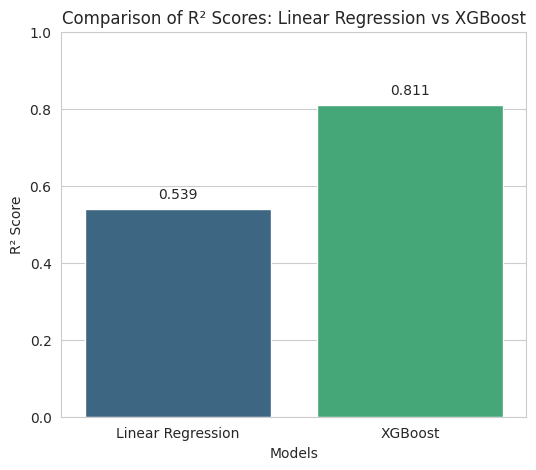

In [34]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Define models and their R² scores
models = ['Linear Regression', 'XGBoost']
r2_scores = [r2_score_linear, r2_score_XGB]

# Set figure size and style
plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")

# Create bar plot
sns.barplot(x=models, y=r2_scores, palette='viridis')

# Labels and title
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Comparison of R² Scores: Linear Regression vs XGBoost')
plt.ylim(0, 1)

# Add text labels on bars
for i, score in enumerate(r2_scores):
    plt.text(i, score + 0.02, f'{score:.3f}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()


<ipython-input-35-24050821f3b5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mse_scores, palette='viridis')


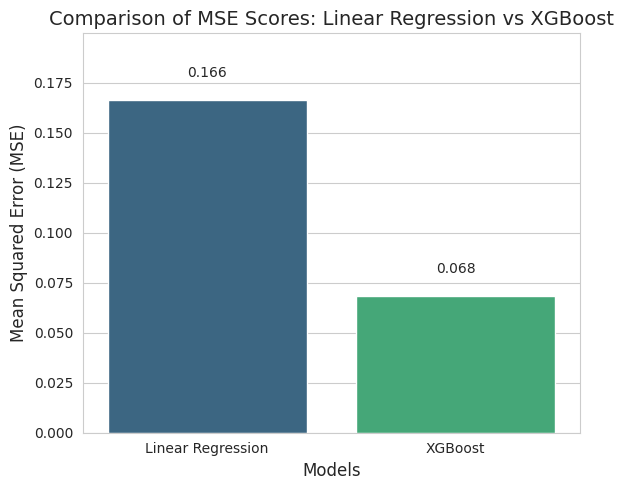

In [35]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Define models and their MSE scores
models = ['Linear Regression', 'XGBoost']
mse_scores = [mse_linear, mse_XGB]

# Set figure size and style
plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")

# Create bar plot
sns.barplot(x=models, y=mse_scores, palette='viridis')

# Labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('Comparison of MSE Scores: Linear Regression vs XGBoost', fontsize=14)
plt.ylim(0, max(mse_scores) * 1.2)  # Adjust y-axis to fit labels

# Add data labels on bars
for i, score in enumerate(mse_scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-36-cf93b93ba856>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_scores, palette='viridis')


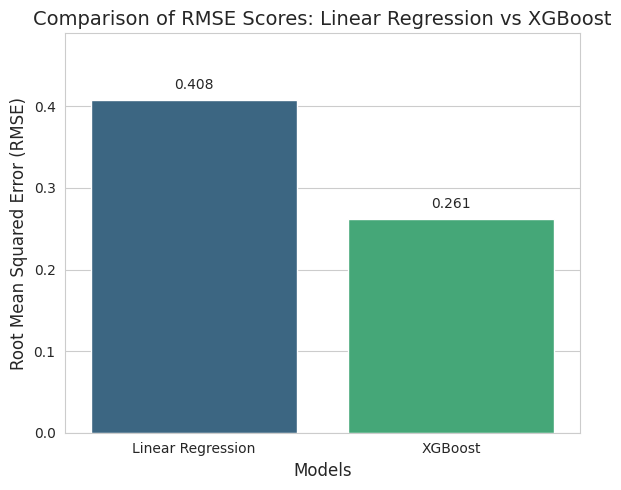

In [36]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Define models and their RMSE scores
models = ['Linear Regression', 'XGBoost']
rmse_scores = [rmse_linear, rmse_XGB]

# Set figure size and style
plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")

# Create bar plot
sns.barplot(x=models, y=rmse_scores, palette='viridis')

# Labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.title('Comparison of RMSE Scores: Linear Regression vs XGBoost', fontsize=14)
plt.ylim(0, max(rmse_scores) * 1.2)  # Adjust y-axis dynamically

# Add data labels on bars
for i, score in enumerate(rmse_scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-37-b824376f18a5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mae_scores, palette='viridis')


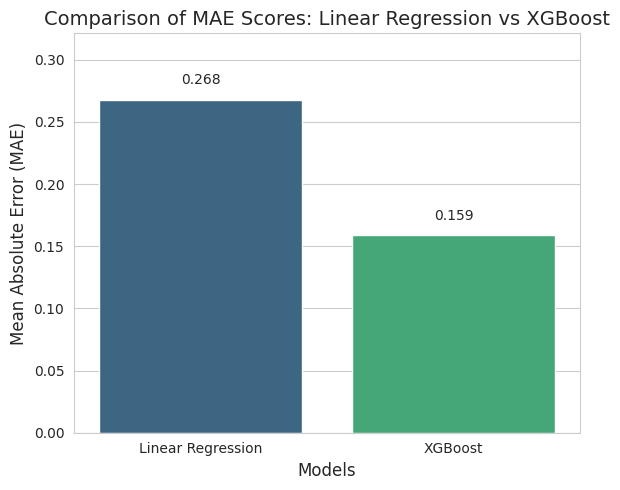

In [37]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Define models and their MAE scores
models = ['Linear Regression', 'XGBoost']
mae_scores = [mae_linear, mae_XGB]

# Set figure size and style
plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")

# Create bar plot
sns.barplot(x=models, y=mae_scores, palette='viridis')

# Labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.title('Comparison of MAE Scores: Linear Regression vs XGBoost', fontsize=14)
plt.ylim(0, max(mae_scores) * 1.2)  # Adjust y-axis dynamically

# Add data labels on bars
for i, score in enumerate(mae_scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


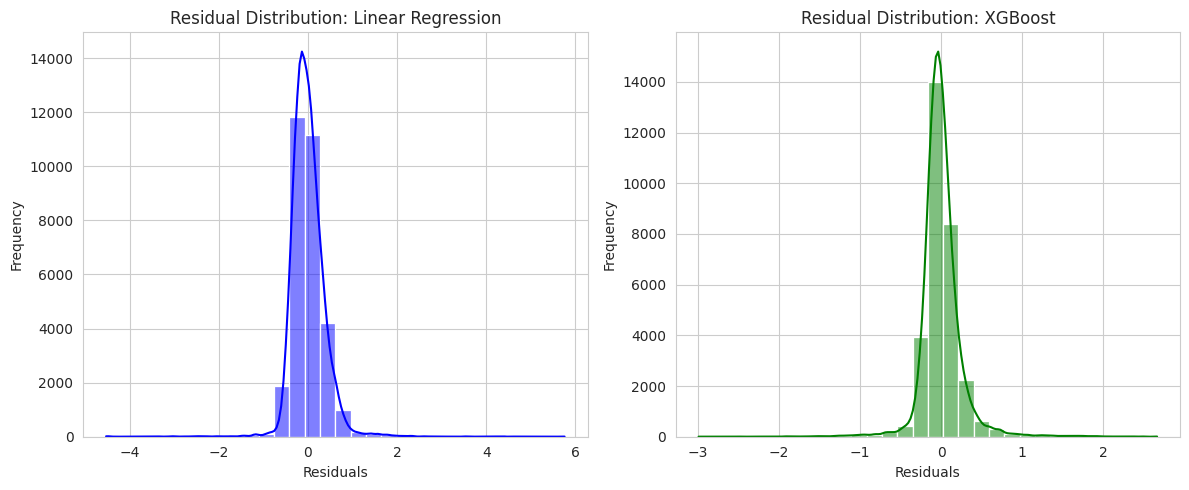

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals_linear = Y_test - y_preds_linear
residuals_XGB = Y_test - y_preds_XGB

# Create subplots
plt.figure(figsize=(12, 5))

# Residual plot for Linear Regression
plt.subplot(1, 2, 1)
sns.histplot(residuals_linear, bins=30, kde=True, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution: Linear Regression')

# Residual plot for XGBoost
plt.subplot(1, 2, 2)
sns.histplot(residuals_XGB, bins=30, kde=True, color='green')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution: XGBoost')

# Show the plot
plt.tight_layout()
plt.show()
